In the last notebook, we used Talos to create a tuned Keras model. Now, we'll see how it performs on other data loaded from the Reverse Beacon Network.

Specifically:

- We've trained a model that looked at data from the first three months of 2019.
- We tried to predict how many stations from the EU would be heard by the VE7CC station on a given day.
- We'll use that model to predict for the second quarter of 2019 (April to June).
- Since we're in the future now too, we'll see how this stacks up against our actual stats during that time.
- We'll plot predicted vs actual values, and graph loss for the model as well.

Let's start with the standard inputs.

In [1]:
# Standard inputs
import pandas as pd
import numpy as np

# Make plots bigger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline

import seaborn as sns
sns.set_palette('bright')

Now, let's load the model from notebook #7.

In [2]:
from keras.models import load_model

# We set `compile=False` here in order to prevent warnings about how
# the model is uncompiled; as we don't want to train the model, but rather 
# only use it, the warning isn't relevant to us.  See: 
# https://stackoverflow.com/a/57054106
model = load_model ('../models/notebook_07-hpb-ve7cc-2019q1-neural-network-tuning.h5',
                   compile=False)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


Let's load the data from 2019Q2 into a Pandas frame.

In [3]:
from src.data.load_dataset import load_dataset, load_and_count_by_band, load_sunspot_dataset
from src.data.utils import count_by_hour, add_sunspots_data, add_time_columns

hourly_20m = load_and_count_by_band(band='20m')
#sunspots_file = '../data/interim/SN_d_tot_V2.0-interim.csv'
#sunspots = load_sunspot_dataset(sunspots_file)

#hourly_20m = add_sunspots_data(hourly_20m, sunspots)
## Let's just make sure the sunspots are showing up...
hourly_20m.head(200).tail()

total  sunspots_count  hour  month    annual  weekend  \
date                                                                         
2018-01-09 23:00:00      0              16    23      1  0.021918      0.0   
2018-01-10 00:00:00      0              20     0      1  0.021918      0.0   
2018-01-10 01:00:00      0              20     1      1  0.021918      0.0   
2018-01-10 02:00:00      0              20     2      1  0.021918      0.0   
2018-01-10 03:00:00      0              20     3      1  0.021918      0.0   

                     arrl_dx_contest  
date                                  
2018-01-09 23:00:00              0.0  
2018-01-10 00:00:00              0.0  
2018-01-10 01:00:00              0.0  
2018-01-10 02:00:00              0.0  
2018-01-10 03:00:00              0.0

Let's get that narrowed down to 2019Q2.

In [4]:
# FIXME: I'm not sure why we have to do this in two steps here -- but 
# when I attempted to do it in one, it gave an "index out of bounds" error.
hourly_20m_2019q2 = hourly_20m.loc[hourly_20m.index >= '2019-04-01']
hourly_20m_2019q2 = hourly_20m_2019q2.loc[hourly_20m_2019q2.index < '2019-07-01']
type(hourly_20m_2019q2)
hourly_20m_2019q2.tail()

total  sunspots_count  hour  month    annual  weekend  \
date                                                                         
2019-06-30 19:00:00      0               0    19      6  1.490411      1.0   
2019-06-30 20:00:00      1               0    20      6  1.493151      1.0   
2019-06-30 21:00:00      0               0    21      6  1.493151      1.0   
2019-06-30 22:00:00      0               0    22      6  1.493151      1.0   
2019-06-30 23:00:00      1               0    23      6  1.493151      1.0   

                     arrl_dx_contest  
date                                  
2019-06-30 19:00:00              0.0  
2019-06-30 20:00:00              0.0  
2019-06-30 21:00:00              0.0  
2019-06-30 22:00:00              0.0  
2019-06-30 23:00:00              0.0

In [5]:
x = hourly_20m_2019q2.drop('total', axis=1)
y = hourly_20m_2019q2['total']
print("Shape of x: {}".format(x.shape))
x.head()

Shape of x: (2184, 6)


sunspots_count  hour  month    annual  weekend  \
date                                                                  
2019-04-01 00:00:00              14     0      4  1.243836      0.0   
2019-04-01 01:00:00              14     1      4  1.243836      0.0   
2019-04-01 02:00:00              14     2      4  1.243836      0.0   
2019-04-01 03:00:00              14     3      4  1.243836      0.0   
2019-04-01 04:00:00              14     4      4  1.243836      0.0   

                     arrl_dx_contest  
date                                  
2019-04-01 00:00:00              0.0  
2019-04-01 01:00:00              0.0  
2019-04-01 02:00:00              0.0  
2019-04-01 03:00:00              0.0  
2019-04-01 04:00:00              0.0

In [6]:
predicted = model.predict(x)
type(predicted)
predicted

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

Now we need to convert that to a dataframe, indexed the same as `x`.

In [39]:
# accuracy = pd.DataFrame({'prediction': predicted}, index=x.index)
y.index
accuracy = pd.DataFrame(predicted, index=x.index)
accuracy = pd.merge(accuracy, y, left_index=True, right_index=True)
accuracy['abs_diff'] = abs(accuracy[0] - accuracy['total'])
accuracy.head()

0  total  abs_diff
date                                     
2019-04-01 00:00:00  0.0      1       1.0
2019-04-01 01:00:00  0.0      0       0.0
2019-04-01 02:00:00  0.0      0       0.0
2019-04-01 03:00:00  0.0      0       0.0
2019-04-01 04:00:00  0.0      0       0.0

Before moving on to accuracy measurements like mean absolute error, let's try something simpler:  a histogram of `abs_diff`.

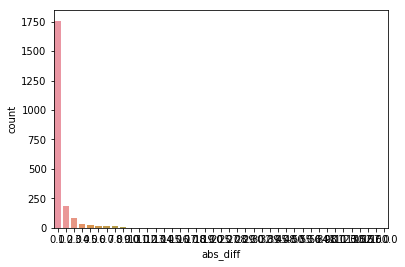

In [40]:
sns.countplot(x='abs_diff', data=accuracy)

That doesn't look bad -- a lot of 0 difference.  But how many of those are due to predicting zero and seeing zero (which seems like a safe bet)?

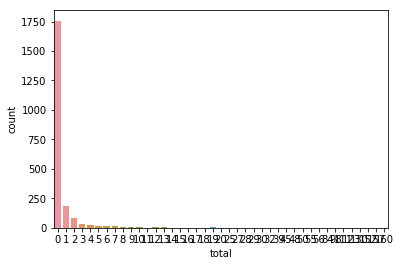

In [42]:
sns.countplot(x='total', data=accuracy)

Seems like we have an awful lot of hours when there are actually zero contacts.  

Still -- let's calculate the mean absolute error.

In [44]:
mae = np.mean(accuracy['abs_diff'])
print(mae)

1.2857142857142858


# NEXT
- Run prediction
- See how it went
  - Graph difference
  - get accuracy measurement

# Done

- Divide up into bands -- at least 20m 
- add sunspot data! 
- verify the time range for the data we have 
- add tests to make sure we're adding sunspot data
- re-run notebook 7 to make sure we are including sunspot data in our work

# TODO

- Originally, we were only loading data from 2019Q1; that assumption is built into the various libraries.  That needs to be changed: we should be able to specify a range that we want to load.
  - One way to do this would be to add `start_date` and `end_date` arguments to `load_dataset()`, which would be 2019Q1 by default.
  - Another way would be to let callees drop ranges as necessary, and adjust the notebooks accordingly so that they're still just dealing with 2019Q1.  I like that idea better.